# 액티브 러닝

## 실습 개요

1) 실습 목적   

이번 실습에서 액티브 러닝을 직접 구현해보고 그 결과를 확인해봅니다. 일반적인 분류기와 액티브 러닝을 활용한 분류기의 차이를 확인할 수 있습니다.

 2) 수강 목표
  - 액티브 러닝을 직접 구현할 수 있다.
  - Uncertainty sampling을 구현할 수 있다.
  - Query-by-committee를 구현할 수 있다.


### 실습 목차
* Uncertainty Sampling 구현하기
  * 1-1 학습 준비
  * 1-2 Random Sampling
  * 1-3 Uncertainty Sampling
* Query-by-committee 구현하기
  * 2-1 Vote Entropy
  * 2-2 Consensus Entropy
  * 2-3 Maximum Disagreement

### 환경 설정
- 패키지 설치 및 임포트

In [1]:
# matplotlib과 seaborn은 시각화 라이브러리들입니다.
!pip install matplotlib seaborn

In [2]:
# numpy는 다차원 배열의 처리를 지원하는 라이브러리입니다.
import numpy as np

# 파이썬 시각화 라이브러리입니다.
import matplotlib.pyplot as plt

# 타입 표시를 위한 모듈입니다.
from typing import Callable, Sequence, Tuple, Optional

# 랜덤 샘플링 함수입니다.
import random
from random import sample

# 머신 러닝 라이브러리인 sklearn에서 머신 러닝 모듈들을 불러와줍니다.
from sklearn.linear_model import LogisticRegression           # 로지스틱 회귀 모형 클래스
from sklearn.ensemble import VotingClassifier                 # Soft voting/Majority rule의 분류기
from sklearn.svm import LinearSVC, SVC                        # 선형 서포트 벡터 분류기, 서포트 벡터 분류기
from sklearn.tree import DecisionTreeClassifier               # 결정 트리 분류기
from sklearn.linear_model import PassiveAggressiveClassifier  # 수동적-공격적 분류기
from sklearn.naive_bayes import GaussianNB                    # 가우시안 나이브 베이지안 분류기
from sklearn.neighbors import KNeighborsClassifier            # 최근접 이웃 분류기

# 임의 데이터 생성을 위한 모듈들을 불러와줍니다.
from scipy.stats import multivariate_normal, ortho_group      # 다변량 정규 확률 변수, 임의 직교 행렬 반환 모듈
from scipy.stats import entropy                               # 주어진 분포의 엔트로피를 계산하는 모듈

# python 시각화 라이브러리
import seaborn as sns
sns.set_style("white")
colors = sns.color_palette(n_colors=10)

## 1. Uncertainty Sampling 구현하기

```
💡 목차 개요 : Random Sampling과 Uncertainty Sampling을 구현해보고 그 차이를 확인해보겠습니다.
```

- 1-1 학습 준비
- 1-2 Random Sampling
- 1-3 Uncertainty Sampling


### 1-1 학습 준비

> 학습에 사용될 데이터를 만들고 데이터 시각화를 위한 설정을 만들겠습니다.



#### 👨‍💻 코드 : (1-1)



**🏭 샘플 데이터 만들기**

In [3]:
# 회전 및 크기 조정을 샘플링하여 임의 공분산 행렬을 구성합니다.
def sample_covar(dim: int = 2, scale_min: float =  .3, scale_max: float = 5) -> np.ndarray:
  # ortho_group.rvs()로 dim 차원의 임의 직교 행렬을 구성한 후 크기를 조정한 임의 행렬과 곱합니다.
  R = ortho_group.rvs(dim) * (np.random.rand(dim, dim) * (scale_max - scale_min) + scale_min)
  # 결과 행렬과 그 전치 행렬의 내적을 구해 임의의 공분산 행렬을 반환합니다.
  return R.dot(R.T)

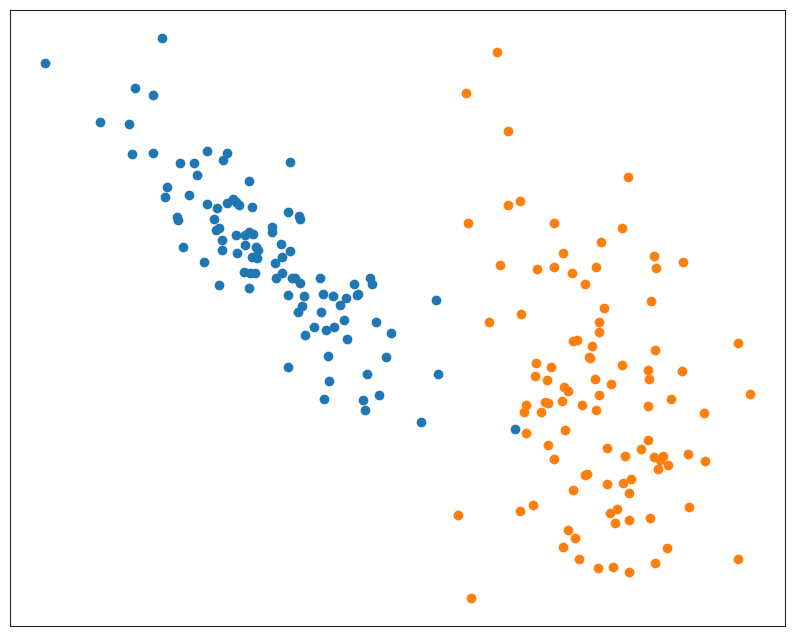

In [4]:
N_1, N_2 = 100, 100  # 각 클라우드의 샘플 수를 지정
mu_1 = [-5, 2]  # 첫 번째 클라우드의 중심
mu_2 = [5, -2]  # 두 번째 클라우드의 중심

random.seed(23) # 시드 설정

# 중심점을 바탕으로 임의의 공분산을 가지는 다변량 정규 분포를 생성한 후 합쳐줍니다.
X = np.concatenate([
  multivariate_normal(mu_1, sample_covar()).rvs(N_1),
  multivariate_normal(mu_2, sample_covar()).rvs(N_2),
])
y = np.concatenate([np.zeros(N_1, int), np.ones(N_2, int)])

# 데이터의 산점도를 그려줍니다.
plt.figure(figsize=(10,8))
plt.scatter(X[y==0, 0], X[y==0, 1], color=colors[0])
plt.scatter(X[y==1, 0], X[y==1, 1], color=colors[1])
plt.xticks(()), plt.yticks(());

**⛺ 시각화 설정하기**

In [5]:
# 왼쪽 하단부터 오른쪽 상단까지 범위를 지정한 직사각형 그리드를 반환합니다.
def meshgrid_from_bounds(lower_left: Sequence[float], upper_right: Sequence[float], *,
                         resolution: float = 0.02) -> Tuple[np.ndarray, np.ndarray]:
  return np.meshgrid(np.arange(lower_left[0], upper_right[0], resolution),
                  np.arange(lower_left[1], upper_right[1], resolution))

# 주어진 범위 내에서 분류기의 결정 경계(deicison boundary)를 시각화합니다.
def plot_decision_boundary(clf, lower_left: Sequence[float], upper_right: Sequence[float], *,
                           resolution: float = 0.02, boundary_color: Tuple[float] = (0.2, 0.2, 0.2)):
  xx, yy = meshgrid_from_bounds(lower_left, upper_right, resolution=resolution)
  # 분류기의 각 클래스에 대한 확률을 반환합니다.
  Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0].reshape(xx.shape)
  plt.contour(xx, yy, Z, levels=[0.5], colors=[boundary_color]) # contour는 등치선 또는 등고선을 그리는 함수입니다.

# 색상을 흰색과 섞어 흐리게 만듭니다.
def lighten(color: Tuple[float], *, amount: float = .6):
  """Blend color with white by the given amount."""
  return tuple(np.array(color) * (1 - amount) + np.array([1, 1, 1]) * amount)


In [6]:
# 학습 데이터와 라벨이 지정되지 않은 데이터의 산점도를 그립니다.
def plot_data(X: np.ndarray, y: np.ndarray, train_idx: Sequence[int], *,
              colors: Sequence[Tuple[float]] = sns.color_palette(n_colors=2)):

  # 모든 데이터
  plt.scatter(X[y==0, 0], X[y==0, 1], color=lighten(colors[0]), s=6)
  plt.scatter(X[y==1, 0], X[y==1, 1], color=lighten(colors[1]), s=6)

  # 학습 데이터
  X_tr = X[train_idx]
  y_tr = y[train_idx]
  plt.scatter(X_tr[y_tr==0, 0], X_tr[y_tr==0, 1], color=colors[0])
  plt.scatter(X_tr[y_tr==1, 0], X_tr[y_tr==1, 1], color=colors[1])
  plt.xticks(()), plt.yticks(());

# 학습 데이터와 라벨이 지정되지 않은 데이터의 산점도와 분류기의 결정 경계를 그립니다.
# 이전 라운드의 결정 경계 또한 함께 그립니다.
def plot_data_and_classifier(X: np.ndarray, y: np.ndarray, train_idx: Sequence[int], clf, *,
                             previous_clf=None, colors: Sequence[Tuple[float]] = sns.color_palette(n_colors=2)):
  # 이전 라운드의 결정 경계를 그립니다.
  if previous_clf is not None:
    plot_decision_boundary(previous_clf, lower_left=X.min(axis=0) - 1, upper_right=X.max(axis=0) + 1, boundary_color=(0.7, 0.7, 0.7))

  # 결정 경계와 산점도를 그립니다.
  plot_decision_boundary(clf, lower_left=X.min(axis=0) - 1, upper_right=X.max(axis=0) + 1)
  plot_data(X, y, train_idx, colors=colors)


### 1-2 Random Sampling

> 액티브러닝을 사용하지 않고 Random Sampling을 했을 때 분류기가 어떻게 변화하는지 확인해보겠습니다.



#### 👨‍💻 코드 : (1-2)



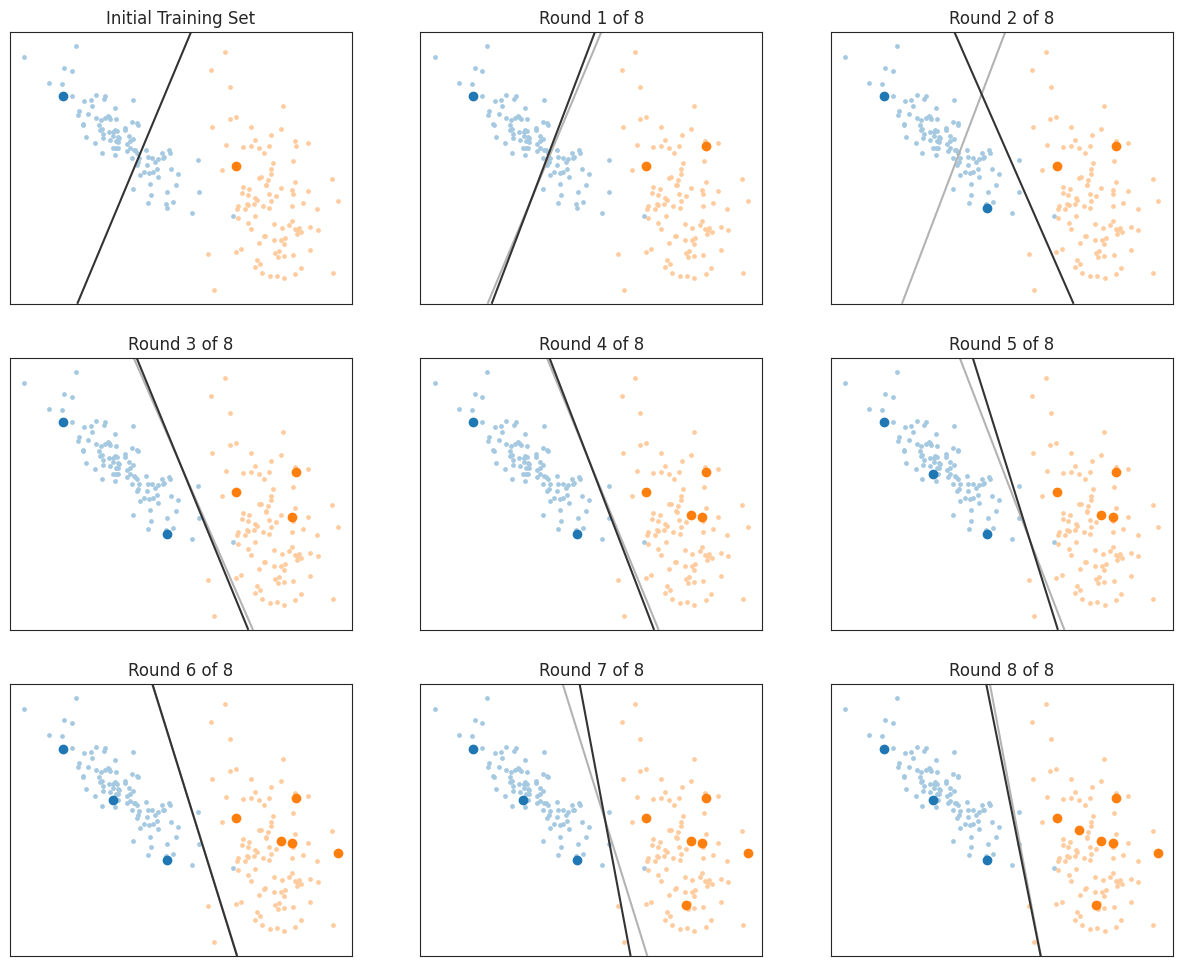

In [7]:
random.seed(112818)  # 결과가 나쁜 예제의 시드를 설정합니다.

# 샘플을 골라 로지스틱 회귀모형에 학습시킵니다.
starting_samples = [np.random.choice(range(N_1)), N_1 + np.random.choice(range(N_2))]
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

# 8개의 추가 학습 데이터를 무작위로 샘플링합니다.
plt.figure(figsize=(15, 12))
plt.subplot(3, 3, 1)
plt.title(f'Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

# 학습 idx에 추가 데이터를 순차적으로 더하고 회귀모형의 변화를 시각화합니다.
for round in range(8):
  new_sample = np.random.choice([i for i in range(N_1 + N_2) if i not in train_idx])
  train_idx.append(new_sample)
  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])

  ax = plt.subplot(3, 3, round+2)
  plt.title(f'Round {round + 1} of 8')
  plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)

### 1-3 Uncertainty Sampling

> Uncertainty Sampling를 사용했을 때 분류기가 어떻게 변화하는지 확인해보겠습니다.



#### 📝 설명 : Uncertainty Sampling

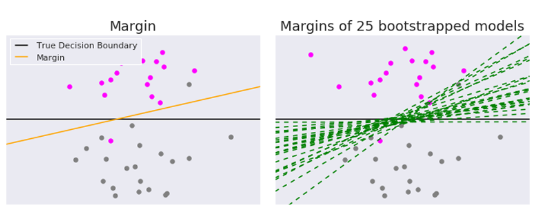

* 불확실성 샘플링(Uncertainty sampling)은 모델의 예측이 가장 불확실한 인스턴스가 학습에 가장 유익하다는 아이디어에 기반하고 있습니다.
* 가장 불확실한 인스턴스에 대한 라벨의 획득이 모델 업데이트에 가장 많은 정보를 제공할 수 있다는 것입니다.
* 불확실성 샘플링에는 보통 아래의 세 가지 접근 방식이 활용되며 예제의 criterion을 바꾸는 것으로 세 가지 방식을 모두 실험해볼 수 있습니다.

* 불확실성 샘플링 접근 방식
  * 최소 신뢰도 : 예측 신뢰도가 가장 낮은 인스턴스를 선택
  * 마진 샘플링 : 두 클래스 간 예측 확률 차이가 가장 작은 인스턴스 선택
  * 엔트로피 기반 샘플링 : 가장 높은 엔트로피를 갖는 인스턴스를 선택

이미지 출처 : [H Jiang et al., Minimum-Margin Active Learning (2019)](https://arxiv.org/abs/1906.00025)


#### 👨‍💻 코드 : (1-3)



In [8]:
# 최소 신뢰 기준을 설정합니다. 추정된 클래스 확률을 받아 그것의 최대값을 빼는 식으로 계산합니다.
def least_confidence(posterior: np.ndarray) -> np.ndarray:
  return 1 - posterior.max(axis=1)

# 최소 마진 기준을 설정합니다. 가장 가능성이 높은 두 클래스의 확률을 빼서 계산합니다.
def minimum_margin(posterior: np.ndarray) -> np.ndarray:
  most_probable = posterior.max(axis=1)
  # 두 번째로 높은 사후 확률을 얻기 위해 마스크를 설정해줍니다.
  mask_most_probable = (posterior == most_probable.reshape(-1, 1))
  second_most_probable = (posterior - mask_most_probable).max(axis=1)
  return second_most_probable - most_probable

# 엔트로피 기준을 설정합니다. 사후 확률의 엔트로피를 계산해 반환합니다.
def entropy_criterion(posterior: np.ndarray) -> np.ndarray:
  return entropy(posterior, axis=1)

# 분류기가 라벨에 대해 가장 불확실한 라벨링 되지 않은 샘플 인덱스를 반환합니다.
def uncertainty_sampling(clf, X: np.ndarray, train_idx: Sequence[int], criterion: Callable[[np.ndarray], np.ndarray]) -> int:
  # 라벨링 되지 않은 샘플 인덱스를 가져옵니다.
  unknown_indices = np.array([i for i in range(X.shape[0]) if i not in train_idx])
  # 분류기의 사후 확률을 계산합니다.
  posterior = clf.predict_proba(X[unknown_indices])
  # 사후 확률을 사용해 기준값을 반환합니다.
  utility = criterion(posterior)
  return unknown_indices[np.argmax(utility)]

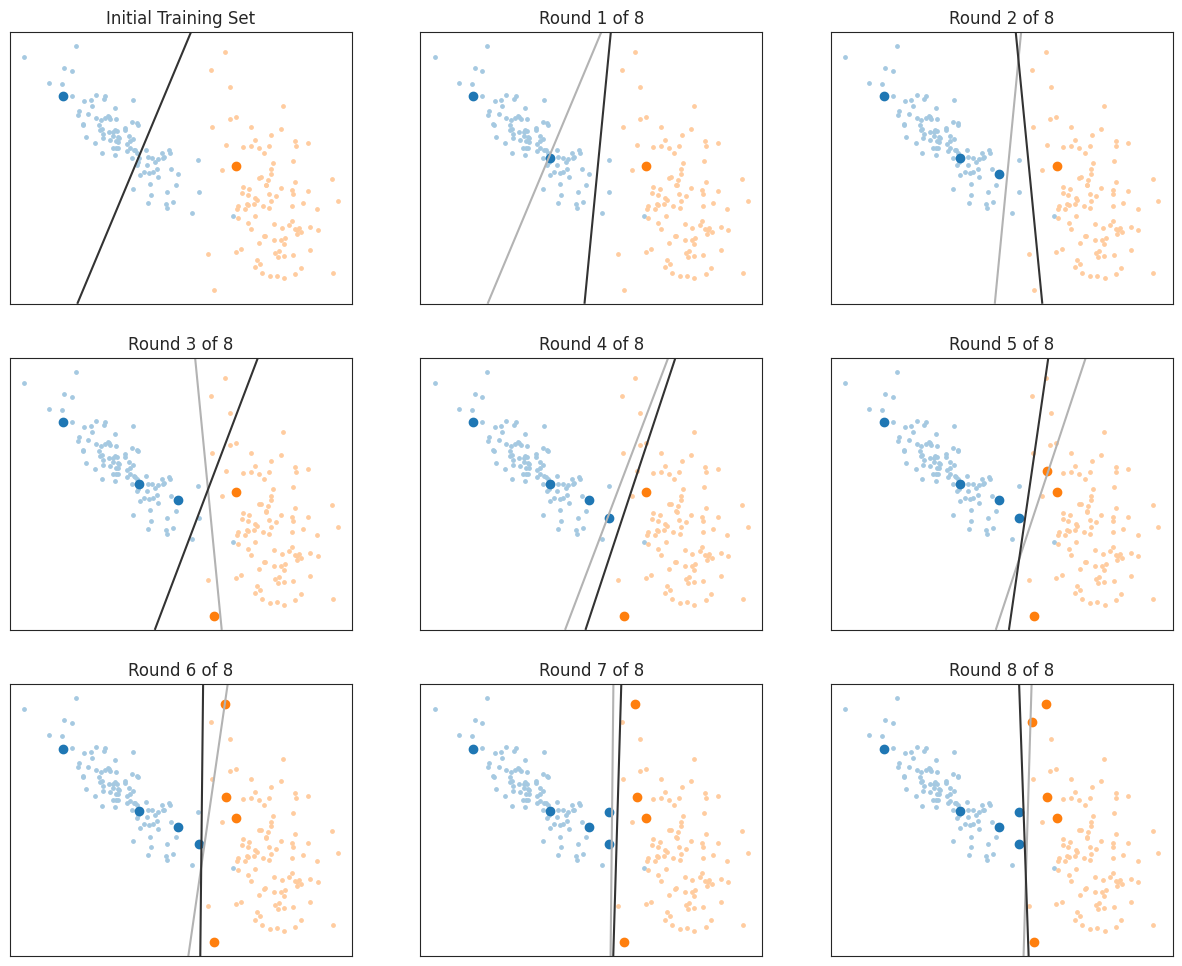

In [9]:
# RandomSampling에서 사용한 것과 같은 샘플로부터 시작합니다.
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

plt.figure(figsize=(15, 12))
plt.subplot(3, 3, 1)
plt.title(f'Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

# 8차례의 불확실성 샘플링을 진행합니다.
# criterion의 함수를 변경함으로 다른 접근 방식의 샘플링을 시험해볼 수 있습니다.
for round in range(8):
  new_sample = uncertainty_sampling(clf, X, train_idx, criterion=entropy_criterion)
  train_idx.append(new_sample)

  plt.subplot(3, 3, round+2)
  plt.title(f'Round {round + 1} of 8')
  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])
  plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)

#### 📚 함께 보면 좋을 자료
* [modAL, Uncertainty sampling](https://modal-python.readthedocs.io/en/latest/content/query_strategies/uncertainty_sampling.html) : Uncertainty sampling에 대해 다룬 자료입니다.
*  [scikit-learn User guide](https://scikit-learn.org/stable/user_guide.html) : 머신 러닝 라이브러리인 scikit-learn에서 지원하는 모델과 그 활용법에 대해 설명되어있습니다.

## 2. Query-by-committee 구현하기

```
💡 목차 개요 : Query-by-committee 방식의 액티브 러닝을 구현해보고 그 결과를 확인해보겠습니다.
```

- 2-1 Vote Entropy
- 2-2 Consensus Entropy
- 2-3 Maximum Disagreement


### 2-1 Vote Entropy

> Vote Entropy는 각 클래스에 대한 투표수를 활용해 엔트로피를 계산합니다.



#### 📝 설명 : Query-by-committee

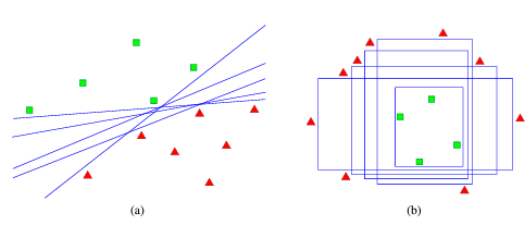

* 모델 불일치를 기반으로 데이터를 샘플링하는 방식으로, 위원회를 구성한 후 위원회가 가장 동의하지 않는 인스턴스를 샘플링합니다.
* 위원회에서 의견 차이가 가장 큰 인스턴스가 가장 유용한 것으로 판단합니다.
* 아래는 Query-by-committee에 활용되는 세 가지 접근 방식입니다.

* Query-by-committee 접근 방식
  * Vote entropy : 위원회 사이의 불일치를 투표로 수량화
  * Consensus entropy : 위원회 사이의 불일치를 낮은 합의 확률로 정량화
  * Maximum disagreement : 위원회 사이의 불일치를 합의 확률과의 차이로 계산

#### 👨‍💻 코드 : (2-1)


In [10]:
# X의 각 feature에 대한 앙상블 투표를 반환합니다.
def get_ensemble_votes(ensemble, X: np.ndarray, n_classes) -> np.ndarray:
  predictions = ensemble._predict(X)
  # np.bincount로 각각의 빈도수를 카운트하고 이를 각 축에 대해 실행합니다.
  return np.apply_along_axis(np.bincount, axis=1, arr=predictions, minlength=n_classes)

# 앙상블 투표의 결정 경계를 시각화합니다.
def plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx):
  xx, yy = meshgrid_from_bounds(X.min(0) - 1, X.max(0) + 1)

  try:
    proba = ensemble.predict_proba(np.c_[xx.ravel(), yy.ravel()])
  except AttributeError:
    votes = get_ensemble_votes(ensemble, np.c_[xx.ravel(), yy.ravel()], n_classes=len(np.unique(y)))
    proba = (votes / len(ensemble.estimators))

  plt.contour(xx, yy, proba[:, 0].reshape(xx.shape), levels=[0.5])
  plot_data(X, y, train_idx)

In [11]:
# 앙상블 투표에 대해 엔트로피를 계산합니다.
def vote_entropy(ensemble: VotingClassifier, X: np.ndarray, train_idx: Sequence[int], n_classes: int) -> int:
  unknown_indices = np.array([i for i in range(X.shape[0]) if i not in train_idx])
  # 빈도수를 받아 투표권으로 활용합니다.
  votes = get_ensemble_votes(ensemble, X[unknown_indices], n_classes=n_classes)
  # 엔트로피 계산 시 분류기 숫자만큼 나눠 평균값을 사용합니다.
  utility = entropy(votes / len(ensemble.estimators), axis=1)
  return unknown_indices[np.argmax(utility)]

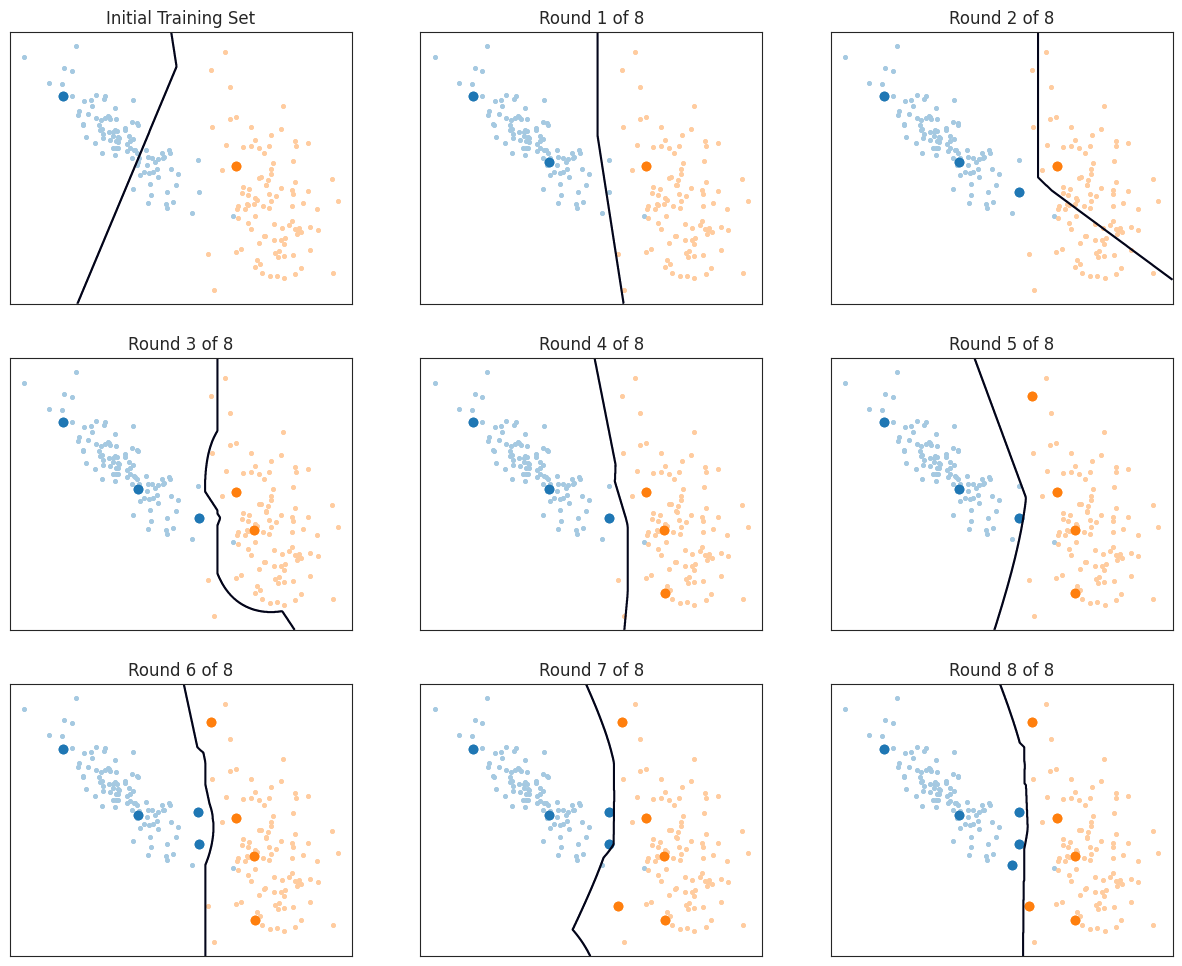

In [12]:
# 여러 기계 학습 모델로 앙상블 모형을 구성합니다.
# voting 방식은 hard입니다.
# hard voting은 0과 1의 결과 숫자를 받는 것이고 soft voting은 확률을 받아 계산하는 것입니다.
train_idx = starting_samples[:]
ensemble = VotingClassifier([
  ('linear svm', LinearSVC(dual=False)),
  ('rbf svm', SVC()),
  ('poly svm', SVC(kernel='poly')),
  ('decision tree', DecisionTreeClassifier()),
  ('passive agressive', PassiveAggressiveClassifier()),
  ('naive bayes', GaussianNB()),
  #('knn', KNeighborsClassifier(n_neighbors=2))
], voting='hard').fit(X[train_idx], y[train_idx])

# 초기 학습 세트로 결정 경계를 그려줍니다.
plt.figure(figsize=(15, 12))
plt.subplot(3, 3, 1)
plt.title(f'Initial Training Set')
plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
plot_data(X, y, train_idx)

# 8차례의 QBC를 진행합니다.
for round in range(8):
  new_sample = vote_entropy(ensemble, X, train_idx, n_classes=2)
  train_idx.append(new_sample)

  plt.subplot(3, 3, round+2)
  plt.title(f'Round {round + 1} of 8')
  ensemble = ensemble.fit(X[train_idx], y[train_idx])
  plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
  plot_data(X, y, train_idx)

### 2-2 Consensus Entropy

> Consensus Entropy는 클래스의 각 합의 확률을 사용해 엔트로피를 계산합니다.



#### 👨‍💻 코드 : (2-2)


In [13]:
# 합의 확률에 대해 엔트로피를 계산합니다.
def consensus_entropy(ensemble: VotingClassifier, X: np.ndarray, train_idx: Sequence[int]) -> int:
  unknown_indices = np.array([i for i in range(X.shape[0]) if i not in train_idx])
  # 앙상블 모형의 확률을 받아옵니다.
  probas = ensemble.predict_proba(X[unknown_indices])
  # 확률값을 바탕으로 엔트로피를 계산합니다.
  utility = entropy(probas, axis=1)
  return unknown_indices[np.argmax(utility)]

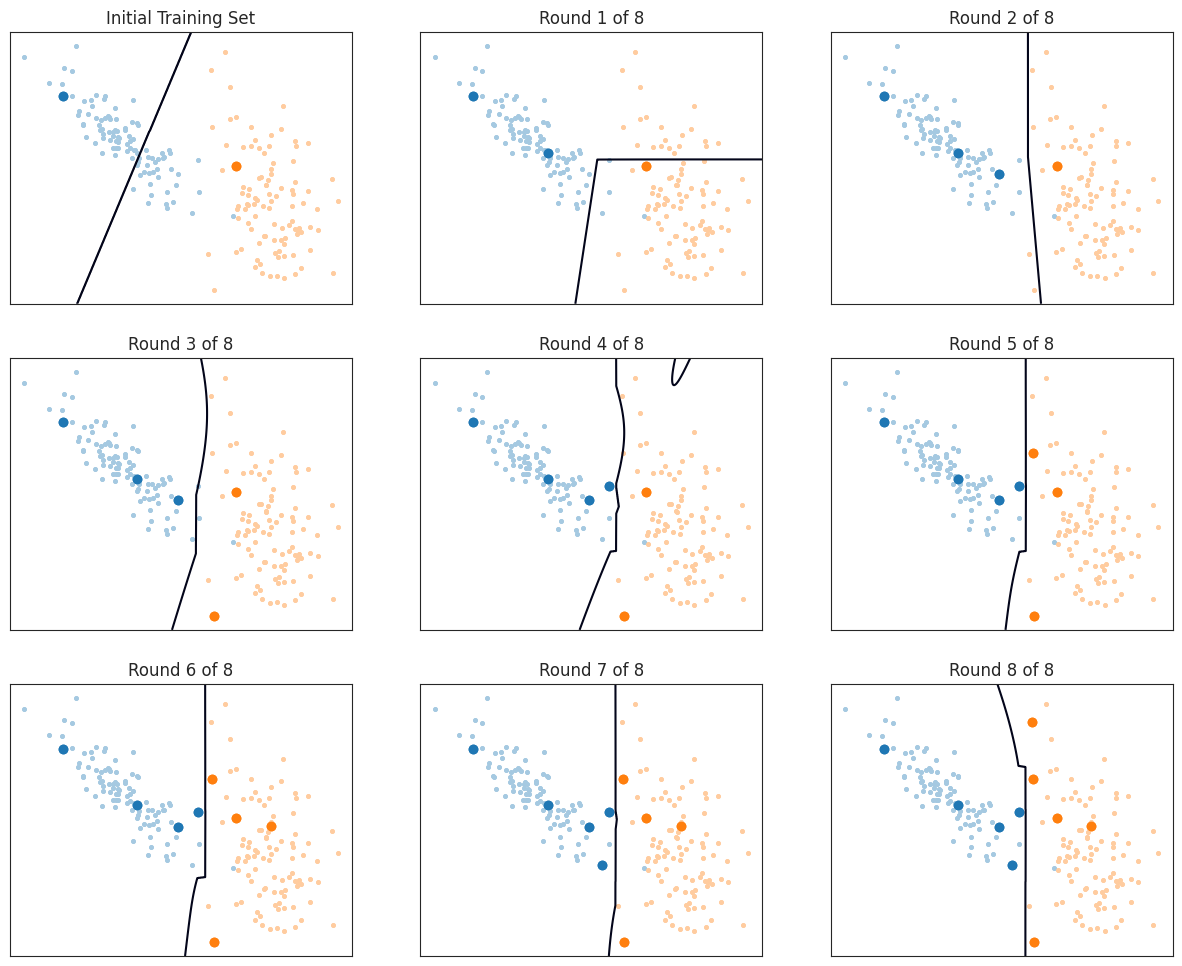

In [14]:
# 여러 기계 학습 모델로 앙상블 모형을 구성합니다.
# soft voting 방식을 사용해 확률값을 받아옵니다.
train_idx = starting_samples[:]
ensemble = VotingClassifier([
  ('logistic regression', LogisticRegression()),
  ('decision tree', DecisionTreeClassifier()),
  ('naive bayes', GaussianNB()),
  ('knn', KNeighborsClassifier(n_neighbors=2))
], voting='soft').fit(X[train_idx], y[train_idx])

# 초기 학습 세트로 결정 경계를 그려줍니다.
plt.figure(figsize=(15, 12))
plt.subplot(3, 3, 1)
plt.title(f'Initial Training Set')
plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
plot_data(X, y, train_idx)

# 8차례의 QBC를 진행합니다.
for round in range(8):
  new_sample = consensus_entropy(ensemble, X, train_idx)
  train_idx.append(new_sample)

  plt.subplot(3, 3, round+2)
  plt.title(f'Round {round + 1} of 8')
  ensemble = ensemble.fit(X[train_idx], y[train_idx])
  plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
  plot_data(X, y, train_idx)

### 2-3 Maximum Disagreement

> 위원회 구성원의 투표 확률과 합의 예측에 대한 각 구성원의 KL Divergence를 계산한 다음 그 중 가장 큰 값을 선택합니다. 다시 말하자면, 합의 예측에 대해 불일치가 가장 큰 인스턴스를 선택하는 것입니다.



#### 👨‍💻 코드 : (2-3)


In [15]:
# 합의 확률을 구한 후 각 클래스에 대한 엔트로피를 구해줍니다.
def max_disagreement(ensemble: VotingClassifier, X: np.ndarray, train_idx: Sequence[int]) -> int:
  unknown_indices = np.array([i for i in range(X.shape[0]) if i not in train_idx])

  probas = ensemble._collect_probas(X[unknown_indices])
  # 앙상블 모형의 확률값의 평균으로 합의 확률을 설정합니다.
  consensus = np.mean(probas, axis=0)
  # 확률값과 합의 확률값을 활용해 엔트로피를 계산합니다.
  utility = np.array([
       np.apply_along_axis(entropy, axis=1, arr=probas[:, i], qk=qk).sum()
       for i, qk in enumerate(consensus)
  ])

  return unknown_indices[np.argmax(utility)]

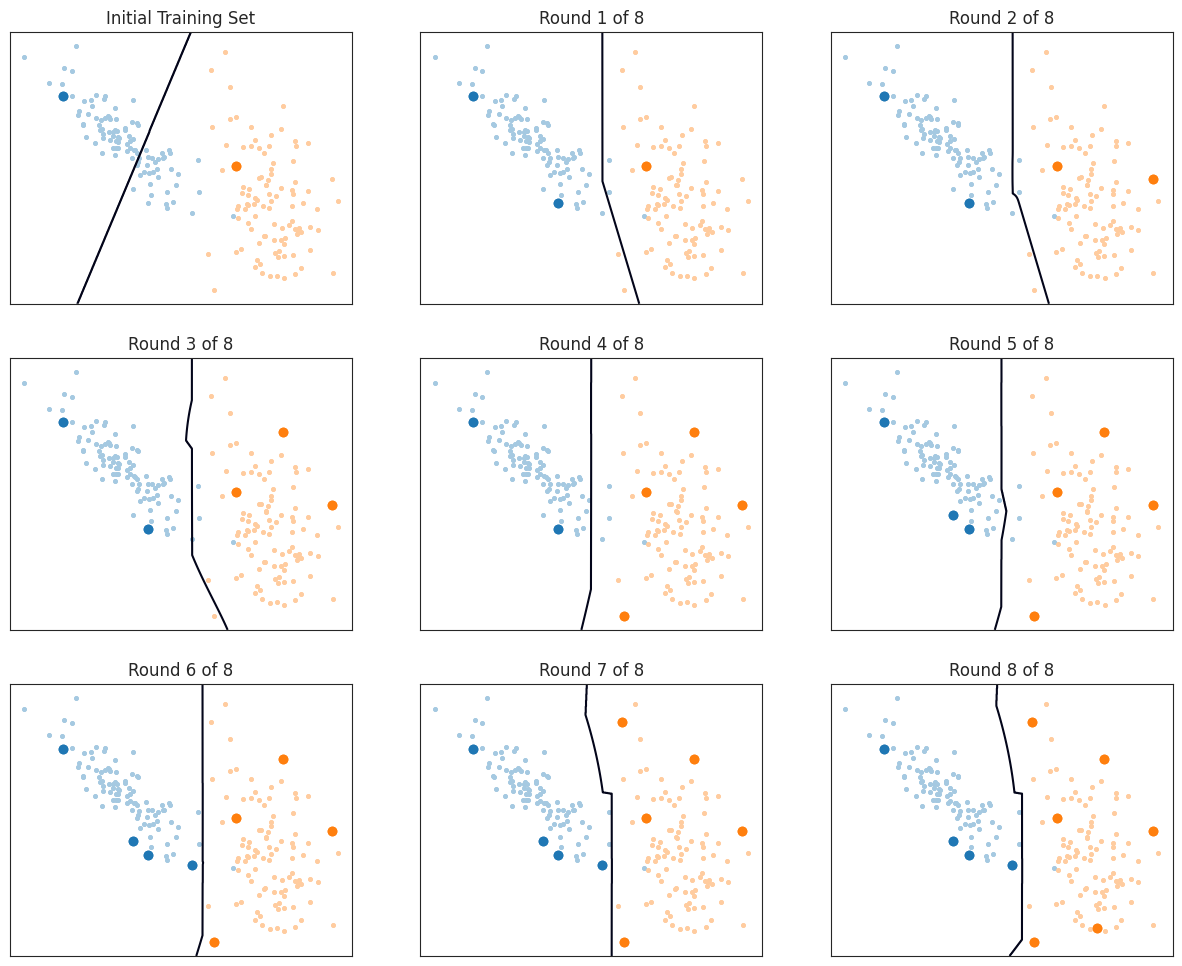

In [16]:
# 여러 기계 학습 모델로 앙상블 모형을 구성합니다.
# soft voting 방식을 사용해 확률값을 받아옵니다.
train_idx = starting_samples[:]
ensemble = VotingClassifier([
  ('logistic regression', LogisticRegression()),
  ('decision tree', DecisionTreeClassifier()),
  ('naive bayes', GaussianNB()),
  ('knn', KNeighborsClassifier(n_neighbors=2))
], voting='soft').fit(X[train_idx], y[train_idx])

# 초기 학습 세트로 결정 경계를 그려줍니다.
plt.figure(figsize=(15, 12))
plt.subplot(3, 3, 1)
plt.title(f'Initial Training Set')
plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
plot_data(X, y, train_idx)

# 8차례의 QBC를 진행합니다.
for round in range(8):
  new_sample = max_disagreement(ensemble, X, train_idx)
  train_idx.append(new_sample)

  plt.subplot(3, 3, round+2)
  plt.title(f'Round {round + 1} of 8')
  ensemble = ensemble.fit(X[train_idx], y[train_idx])
  plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
  plot_data(X, y, train_idx)

#### 📚 함께 보면 좋을 자료


* [modAL, Disagreement sampling](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Disagreement-sampling.html) : Disagreement Sampling에 대해 다룬 자료입니다.
*  [B Settles, Active Learning Literature Survey (2010)](http://burrsettles.com/pub/settles.activelearning.pdf) : 액티브 러닝의 시나리오, 전략, 분석 등 다양한 측면을 다루고 있는 survey 자료입니다.

#Reference

- [intro-to-active-learning](https://github.com/inovex/intro-to-active-learning/blob/main/Intro_to_Active_Learning.ipynb)
- [modAL: A modular active learning framework for Python3](https://modal-python.readthedocs.io/en/latest/index.html)

## Required Package

matplotlib==3.7.1  
seaborn==0.12.2    
scikit-learn==1.2.2   
scipy==0.11.3

## 콘텐츠 라이선스

저작권 : <font color='blue'> <b> ©2023 by Upstage X fastcampus Co., Ltd. All rights reserved.</font></b>

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지 및 패스트캠퍼스에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. </b>